In [1]:
import torch
from torch.distributions.categorical import Categorical
import numpy as np
import matplotlib.pyplot as plt
!pip install pymdptoolbox
import mdptoolbox.example
import pickle

plt.rcParams.update({"font.size": 20})

In [0]:
def magic_box(x):
    """Magic Box Operator. x are log-probabilities"""
    return torch.exp(x - x.detach())

def gae(rewards, values, mask, tau=1.0, gamma_weighted=False):
    """Generalised Advantage Estimation https://arxiv.org/abs/1506.02438"""
    values = values * mask
    deltas = rewards + gamma * values[:,1:] - values[:,:-1]
    advantages = torch.zeros_like(deltas).float()
    gae = torch.zeros_like(deltas[:,0]).float()
    for i in range(deltas.size(1) - 1, -1, -1):
        gae = gae * gamma * tau + deltas[:, i]
        advantages[:,i] = gae
    if gamma_weighted:
        gamma_weights = torch.cumprod(torch.ones_like(advantages) * gamma, 1) / gamma
        advantages = advantages * gamma_weights
    return advantages

def make_objective(batch_data, v_fn, tau=1.0, dice_lambda=1.0, use_dice=False, gamma_weighted=True):
    """Make objective for DiCE, Loaded DiCE, or classic surrogate loss"""
    (batch_states, batch_pi_taken, batch_a_taken,
        batch_r, batch_dones, batch_mask, ep_returns) = batch_data
    empty_mask = (1 - batch_mask[:,:-1]).type(torch.ByteTensor)
    batch_pi_taken[empty_mask] = 1.0
    log_pi = torch.log(batch_pi_taken)
    batch_values = v_fn(batch_states).detach()
    advantages = gae(batch_r, batch_values, batch_mask, tau=tau, gamma_weighted=gamma_weighted)
    if use_dice == "old":
        log_pi_cumsum = torch.cumsum(log_pi, 1)
        deps = magic_box(log_pi_cumsum)
        batch_r[:,-1] = batch_r[:,-1] + batch_values[:,-1]*gamma
        if gamma_weighted:
            gamma_weights = torch.cumprod(torch.ones_like(advantages) * gamma, 1) / gamma
            batch_r = batch_r * gamma_weights
        obj = (batch_r * deps).sum(1).mean()
    elif use_dice == "loaded":
        weighted_cumsum = torch.zeros_like(log_pi)
        weighted_cumsum[:,0] = log_pi[:,0]
        for t in range(1, log_pi.size(1)):
            weighted_cumsum[:,t] = dice_lambda * weighted_cumsum[:,t-1] + log_pi[:,t]
        deps_exclusive = weighted_cumsum - log_pi
        full_deps = magic_box(weighted_cumsum) - magic_box(deps_exclusive)
        obj = (advantages * full_deps).sum(1).mean()
    else:
        obj = (advantages * log_pi).sum(1).mean()
    return obj

def get_P_pi(P, pi):
    """State transition function induced by MDP transition P and policy pi"""
    return (pi.softmax(0).unsqueeze(-1) * P).sum(0)

def get_V(S0, P_pi, R, gamma):
    """Analytically compute V for small MDPs"""
    return (S0 @ torch.inverse(torch.eye(S0.size(0)) - gamma*P_pi) * R).sum()

def sample(batch_size, max_steps=50, params=None):
    """Sample a batch of episodes from the MDP"""
    ep_returns = []
    if params is None:
        params = pi

    batch_states = torch.zeros([batch_size, max_steps+1])
    batch_pi_taken = torch.zeros([batch_size, max_steps])
    batch_a_taken = torch.zeros([batch_size, max_steps])
    batch_r = torch.zeros([batch_size, max_steps])
    batch_dones = torch.zeros([batch_size, max_steps])
    batch_mask = torch.ones([batch_size, max_steps+1])
    
    state = Categorical(S0.unsqueeze(0).repeat(batch_size,1)).sample()
    
    for t in range(max_steps):
        r = R[state]
        probs = params[:,state].softmax(0).transpose(0,1)
        actions = Categorical(probs).sample()
        pi_taken = probs.gather(1, actions.unsqueeze(1)).squeeze(1)
        p_next = P[actions,state]
        next_state = Categorical(p_next).sample()

        batch_states[:,t] = state
        batch_pi_taken[:,t] = pi_taken
        batch_r[:,t] = r
        state = next_state
    batch_states[:, -1] = state

    return batch_states, batch_pi_taken, batch_a_taken, batch_r, batch_dones, batch_mask, ep_returns


In [0]:
np.random.seed(0)
torch.manual_seed(0)
n_states = 5
n_actions = 4
S0 = torch.ones(n_states) / n_states
P, R = mdptoolbox.example.rand(n_states, n_actions)
P = torch.tensor(P, dtype=torch.float)
R = (torch.randn(n_states) + 5) * 10
noise = 0.0
gamma = 0.95
pi = torch.randn(n_actions, n_states, requires_grad=True)

P_pi = get_P_pi(P, pi)
V = get_V(S0, P_pi, R, gamma)
V_s = torch.zeros(n_states)
for s in range(n_states):
    V_s[s] = get_V(torch.eye(n_states)[s], P_pi, R, gamma).detach() + torch.randn_like(V) * noise
    
v_fn = lambda s: V_s[s.long()].detach()

# batch_sizes = [4**n for n in range(3,9)] # bigger batches take longer, show estimator unbiasedness
batch_sizes = [4**n for n in range(3,7)]
n_orders = 3
n_seeds = 5

In [0]:
def corr_obj(tau, dice_method, lam=1.0):
    """Get derivatives up to n_orders"""
    data = {}  # bs: [order: [seed1, ...]]
    print(f"{dice_method}, tau={tau}, lambda={lam}")
    for batch_size in batch_sizes:
        print("bs", batch_size)
        data[batch_size] = [[] for _ in range(n_orders)]
        for seed in range(n_seeds):
            batch_data = sample(batch_size)
            obj = make_objective(batch_data, v_fn, tau, use_dice=dice_method,
                                 dice_lambda=lam, gamma_weighted=True)

            grad = torch.autograd.grad(obj, pi, retain_graph=True, create_graph=True)[0]
            data[batch_size][0].append(grad.detach().numpy().flatten())
            for order in range(1, n_orders):
                # We only differentiate one element of the derivative to the next order
                grad = torch.autograd.grad(grad[0][0], pi, retain_graph=True, create_graph=True)[0]
                data[batch_size][order].append(grad.detach().numpy().flatten())
    return data

def get_true_grads():
    true_grads = []
    true_grad = torch.autograd.grad(V, pi, retain_graph=True, create_graph=True)[0]
    true_grads.append(true_grad.detach().numpy().flatten())
    for order in range(n_orders - 1):
        true_grad = torch.autograd.grad(true_grad[0][0], pi, retain_graph=True, create_graph=True)[0]
        true_grads.append(true_grad.detach().numpy().flatten())
    return true_grads

In [0]:
def run_corr_exp():
    old_dice_data = corr_obj(1.0, "old") # DiCE
    betterbase_data = corr_obj(1.0, "loaded") # Mao et al. corresponds to Loaded DiCE with tau=1.0
    lambda_data = corr_obj(0.0, "loaded") # Loaded DiCE, tau=0.0
    lvc_data = corr_obj(1.0, "loaded", lam=0.0) # LVC corresponds to Loaded DiCE with tau=1.0, lamda=0.0
    true_grads = get_true_grads()
    full_data = [old_dice_data, betterbase_data, lambda_data, lvc_data, true_grads]

    with open("corr_results_demo.pkl", "wb") as f:
        pickle.dump(full_data, f)

def plot_corr_exp():
    with open("corr_results_demo.pkl", "rb") as f:
        full_data = pickle.load(f)

    true_grads = full_data[-1]
    full_data = full_data[:-1]
    full_corr_data = []

    for data in full_data:
        corr_data = {}
        for bs in batch_sizes:
            corr_data[bs] = [{} for _ in range(n_orders)]
            for order in range(n_orders):
                corrs = []
                grads = []
                for seed in range(n_seeds):
                    corrs.append(np.corrcoef(data[bs][order][seed], true_grads[order])[0][1])
                    grads.append(data[bs][order][seed])
                grad_std = np.std(np.stack(grads), 0).mean()

                corr_mean = np.mean(corrs)
                corr_std = np.std(corrs)
                corr_sem = corr_std / np.sqrt(n_seeds)
                corr_data[bs][order]["mean"] = corr_mean
                corr_data[bs][order]["std"] = corr_std
                corr_data[bs][order]["sem"] = corr_sem
                corr_data[bs][order]["grad_std"] = grad_std
        full_corr_data.append(corr_data)

    fig, axes = plt.subplots(1, n_orders, figsize=(22,6))

    axes_labels = ["1st Order", "2nd Order", "3rd Order"]

    for order in range(n_orders):
        ax = axes[order]
        for i, method in enumerate(["DiCE", "Mao et al.", "Ours", "LVC"]):
            corr_data = full_corr_data[i]
            ys = [corr_data[bs][order]["mean"] for bs in batch_sizes]
            errs = [corr_data[bs][order]["sem"] for bs in batch_sizes]
            ax.errorbar(batch_sizes, ys, yerr=errs, linestyle="None", marker='x', label=method, markersize=12,
                        elinewidth=2, markeredgewidth=2)
        ax.set_xscale('log')
        ax.set_ylim(-0.2,1.1)
        ax.set_xlabel(axes_labels[order])
    axes[0].set_ylabel("Correlation with true derivative")
    axes[0].legend(loc = "lower right")

    fig.tight_layout()
    fig.savefig("corr_demo.png")

old, tau=1.0, lambda=1.0
bs 64
bs 256
bs 1024
bs 4096
loaded, tau=1.0, lambda=1.0
bs 64
bs 256
bs 1024
bs 4096
loaded, tau=0.0, lambda=1.0
bs 64
bs 256
bs 1024
bs 4096
loaded, tau=1.0, lambda=0.0
bs 64
bs 256
bs 1024
bs 4096


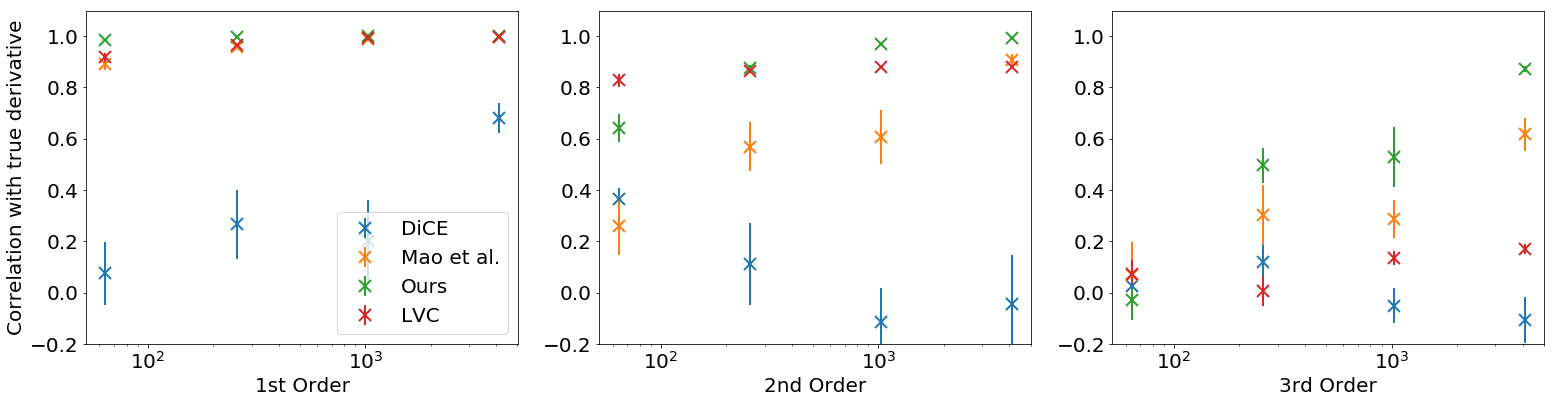

In [6]:
# Check the correlation of different estimators with the true derivatives as a function of batch size

run_corr_exp()
plot_corr_exp()

In [0]:
def run_lam_experiment():
    data = {} # metric: [order: [seed1, ...]]

    lams = [1.0, 0.75, 0.5, 0.25, 0.0]
    batch_size = 512
    n_orders = 3
    n_seeds = 50
    for lam in lams:
        print(lam)
        data[lam] = [[] for _ in range(n_orders)]
        for seed in range(n_seeds):
            batch_data = sample(batch_size, max_steps=50)
            obj = make_objective(batch_data, v_fn, tau=0.0, use_dice="loaded",
                                 dice_lambda=lam, gamma_weighted=True)

            grad = torch.autograd.grad(obj, pi, retain_graph=True, create_graph=True)[0]
            data[lam][0].append(grad.detach().numpy().flatten())
            for order in range(1, n_orders):
                grad = torch.autograd.grad(grad[0][0], pi, retain_graph=True, create_graph=True)[0]
                data[lam][order].append(grad.detach().numpy().flatten())

    true_grads = []
    true_grad = torch.autograd.grad(V, pi, retain_graph=True, create_graph=True)[0]
    true_grads.append(true_grad.detach().numpy().flatten())
    for order in range(n_orders - 1):
        true_grad = torch.autograd.grad(true_grad[0][0], pi, retain_graph=True, create_graph=True)[0]
        true_grads.append(true_grad.detach().numpy().flatten())

    full_data = [data, true_grads]

    with open("lam_results.pkl", "wb") as f:
        pickle.dump(full_data, f)

def plot_lam_experiment(agg=True, param=0):
    with open("lam_results.pkl", "rb") as f:
        full_data = pickle.load(f)

    data, true_grads = full_data

    proc_data = {}
    n_orders = 3
    n_seeds = 50

    lams = list(data.keys())
    for lam in lams:
        proc_data[lam] = [{} for _ in range(n_orders)]
        for order in range(n_orders):
            diffs, grads = [], []
            for seed in range(n_seeds):
                diffs.append((data[lam][order][seed] - true_grads[order]))
                grads.append(data[lam][order][seed])

            diffs = np.stack(diffs)
            grads = np.stack(grads)
            grads_mean = np.mean(grads, 0)
            stds = np.std(grads, 0)
            if agg:
                bias_mean = np.abs(diffs.mean(0)).mean()
            else:
                bias_mean = np.abs(diffs.mean(0))[param]

            # picking a single param gives better error analysis but increases variance
            if agg:
                bias_std = np.std(diffs, 0).mean()
            else:
                bias_std = np.std(diffs, 0)[param]

            bias_sem = bias_std / np.sqrt(n_seeds)
            proc_data[lam][order]["bias_mean"] = bias_mean
            proc_data[lam][order]["bias_std"] = bias_std
            proc_data[lam][order]["bias_sem"] = bias_sem

            if agg:
                stds_mean = np.mean(stds)
            else:
                stds_mean = stds[param]
            proc_data[lam][order]["std_mean"] = stds_mean
            # https://stats.stackexchange.com/questions/631/standard-deviation-of-standard-deviation
            proc_data[lam][order]["std_sem"] = stds_mean * np.sqrt(np.e * (1 - 1 / n_seeds) ** (n_seeds - 1) - 1)

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    min_bias, min_std = 9e9, 9e9
    max_bias, max_std = -9e9, -9e9

    labels = ["1st", "2nd", "3rd"]

    for order in range(0, 3):
        biases = [proc_data[lam][order]["bias_mean"] for lam in lams]
        min_bias = min([min_bias] + biases)
        max_bias = max([max_bias] + biases)
        bias_errs = [proc_data[lam][order]["bias_sem"] for lam in lams]
        axes[0].errorbar(lams, biases, yerr=bias_errs, linestyle="None", marker='x', label=order+1, markersize=12,
                        elinewidth=2, markeredgewidth=2)
        stds = [proc_data[lam][order]["std_mean"] for lam in lams]
        stds_err = [proc_data[lam][order]["std_sem"] for lam in lams]
        min_std = min([min_std] + stds)
        max_std = max([max_std] + stds)
        axes[1].errorbar(lams, stds, yerr=stds_err, linestyle="None", marker='x', label=labels[order], markersize=12,
                        elinewidth=2, markeredgewidth=2)

    axes[1].legend(title="Order", loc="center left")
    axes[0].set_ylim(0, max_bias*1.1)
    axes[1].set_ylim(min_std*0.9, max_std*1.1)
    axes[0].set_ylabel("Bias")
    axes[1].set_ylabel("Std")
    axes[0].set_xlabel(r"DiCE $\lambda$")
    axes[1].set_xlabel(r"DiCE $\lambda$")

    fig.tight_layout()
    fig.savefig("lambda_trade_demo.png")

1.0
0.75
0.5
0.25
0.0


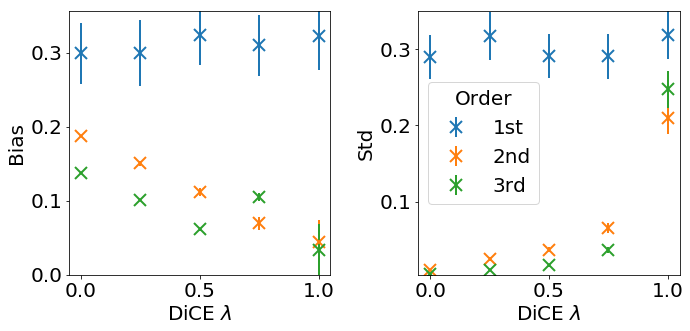

In [8]:
# Trade off bias and variance in higher-order derivatives by discounting the effect of more distant causal dependencies

run_lam_experiment()
plot_lam_experiment()

In [0]:
def run_tau_experiment():
    data = {} # metric: [order: [seed1, ...]]

    taus = [1.0, 0.75, 0.5, 0.25, 0.0]
    batch_size = 512
    n_orders = 3
    n_seeds = 50
    for tau in taus:
        print(tau)
        data[tau] = [[] for _ in range(n_orders)]
        for seed in range(n_seeds):
            batch_data = sample(batch_size, max_steps=50)
            obj = make_objective(batch_data, v_fn, tau=tau, use_dice="loaded",
                                 dice_lambda=1.0, gamma_weighted=True)

            grad = torch.autograd.grad(obj, pi, retain_graph=True, create_graph=True)[0]
            data[tau][0].append(grad.detach().numpy().flatten())
            for order in range(1, n_orders):
                grad = torch.autograd.grad(grad[0][0], pi, retain_graph=True, create_graph=True)[0]
                data[tau][order].append(grad.detach().numpy().flatten())

    true_grads = []
    true_grad = torch.autograd.grad(V, pi, retain_graph=True, create_graph=True)[0]
    true_grads.append(true_grad.detach().numpy().flatten())
    for order in range(n_orders - 1):
        true_grad = torch.autograd.grad(true_grad[0][0], pi, retain_graph=True, create_graph=True)[0]
        true_grads.append(true_grad.detach().numpy().flatten())

    full_data = [data, true_grads]

    with open("tau_results.pkl", "wb") as f:
        pickle.dump(full_data, f)

def plot_tau_experiment(agg=True, param=0):
    with open("tau_results.pkl", "rb") as f:
        full_data = pickle.load(f)

    data, true_grads = full_data

    proc_data = {}
    n_orders = 3
    n_seeds = 50

    taus = list(data.keys())
    for tau in taus:
        proc_data[tau] = [{} for _ in range(n_orders)]
        for order in range(n_orders):
            diffs, grads = [], []
            for seed in range(n_seeds):
                diffs.append((data[tau][order][seed] - true_grads[order]))
                grads.append(data[tau][order][seed])
            diffs = np.stack(diffs)
            grads = np.stack(grads)
            grads_mean = np.mean(grads, 0)
            stds = np.std(grads, 0)

            if agg:
                bias_mean = np.abs(diffs.mean(0)).mean()
            else:
                bias_mean = np.abs(diffs.mean(0))[param]

            bias_std = np.std(diffs, 0)[param]
            bias_sem = bias_std / np.sqrt(n_seeds)
            proc_data[tau][order]["bias_mean"] = bias_mean
            proc_data[tau][order]["bias_std"] = bias_std
            proc_data[tau][order]["bias_sem"] = bias_sem

            if agg:
                stds_mean = np.mean(stds)
            else:
                stds_mean = stds[param]
            proc_data[tau][order]["std_mean"] = stds_mean

            # https://stats.stackexchange.com/questions/631/standard-deviation-of-standard-deviation
            proc_data[tau][order]["std_sem"] = stds_mean * np.sqrt(np.e * (1 - 1/n_seeds)**(n_seeds-1) - 1)

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    min_bias, min_std = 9e9, 9e9
    max_bias, max_std = -9e9, -9e9

    labels = ["1st", "2nd", "3rd"]

    for order in range(0, 3):
        biases = [proc_data[tau][order]["bias_mean"] for tau in taus]
        min_bias = min([min_bias] + biases)
        max_bias = max([max_bias] + biases)
        bias_errs = [proc_data[tau][order]["bias_sem"] for tau in taus]
        axes[0].errorbar(taus, biases, yerr=bias_errs, linestyle="None", marker='x', markersize=12,
                        elinewidth=2, markeredgewidth=2)
        stds = [proc_data[tau][order]["std_mean"] for tau in taus]
        stds_err = [proc_data[tau][order]["std_sem"] for tau in taus]
        min_std = min([min_std] + stds)
        max_std = max([max_std] + stds)
        axes[1].errorbar(taus, stds, yerr=stds_err, linestyle="None", marker='x', label=labels[order], markersize=12,
                        elinewidth=2, markeredgewidth=2)

    axes[1].legend(title="Order", loc="upper left")
    axes[0].set_ylim(0, max_bias*1.1)
    axes[1].set_ylim(min_std*0.9, max_std*1.1)
    axes[0].set_ylabel("Bias")
    axes[1].set_ylabel("Std")
    axes[0].set_xlabel(r"GAE $\tau$")
    axes[1].set_xlabel(r"GAE $\tau$")

    fig.tight_layout()
    fig.savefig("tau_trade_demo.png")

In [0]:
# Trade off bias and variance due to advantage estimator

# For this we approximate a biased value function by adding some random noise
# torch.manual_seed(0)
noise = 10.0
for s in range(n_states):
  V_s[s] = get_V(torch.eye(n_states)[s], P_pi, R, gamma).detach() + torch.randn_like(V) * noise
    
v_fn = lambda s: V_s[s.long()].detach()

1.0
0.75
0.5
0.25
0.0


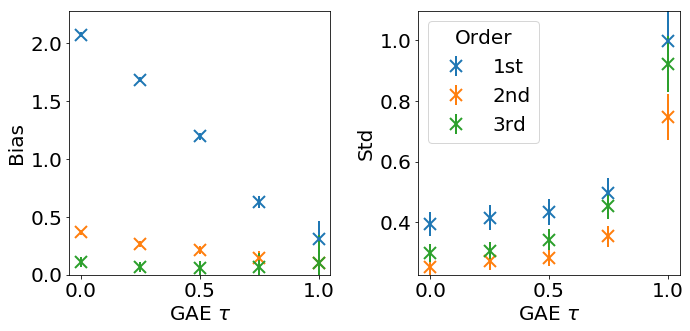

In [11]:
run_tau_experiment()
plot_tau_experiment()